# Bayesian Neural Netowrk
Machine learning models are usually developed from data as deterministic machines that map input to output using a point estimate of parameter weights calculated by maximum-likelihood methods. However, there is a lot of statistical fluke going on in the background. For instance, a dataset itself is a finite random set of points of arbitrary size from a unknown distribution superimposed by additive noise, and for such a particular collection of points, different models (i.e. different parameter combinations) might be reasonable. Hence, there is some uncertainty about the parameters and predictions being made. Bayesian statistics provides a framework to deal with the so-called aleoteric and epistemic uncertainty, which we will demonstrate in the remaining of the tutorials

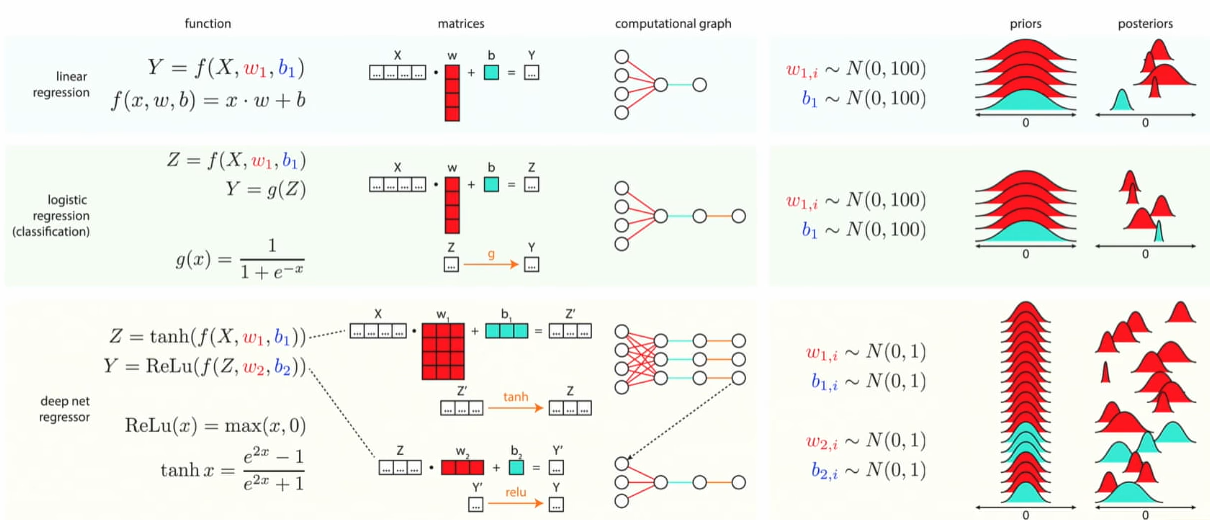
[Image source](https://ericmjl.github.io/bayesian-deep-learning-demystified/#/IntroductionSlide)

## Acknowledgements
The main intuition of the notebooks is built on top of the comprehensive Bayesian Neural Network tutorials made by Ritchie Vink. Please check out his detailed explainations on Bayesian Neural Network at https://www.ritchievink.com/

# Imports

In [ ]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
import torch.distributions as dist
from sklearn import datasets
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp

from IPython.display import Image

# Initialization

## Set random seed

In [ ]:
RANDOM_SEED = 2021
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED) 

## Set device

In [ ]:
# Use the GPU provided by Google Colab if run time is GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Regression

## Generate artificial dataset

In [ ]:
def load_dataset_1(n=150):
    '''
    Generate an artificial dataset in which noise dependent on X
    Args:
      n: number of artificial points
    '''
    np.random.seed(43)

    w0 = 0.125
    b0 = 5
    x_range = [-20, 60]

    def s(x):
        g = (x - x_range[0]) / (x_range[1] - x_range[0])
        return 3 * (0.25 + g**2.)

    # noise dependent on X
    x = (x_range[1] - x_range[0]) * np.random.rand(n) + x_range[0]
    eps = np.random.randn(n) * s(x)
    y = (w0 * x * (1. + np.sin(x)) + b0) + eps
    y = (y - y.mean()) / y.std()
    idx = np.argsort(x)
    x = x[idx]
    y = y[idx]
    return x[:, None], y[:, None]

X, Y = load_dataset_1()
print('X shape:', X.shape)
print('Y shape:', Y.shape)

X shape: (150, 1)
Y shape: (150, 1)


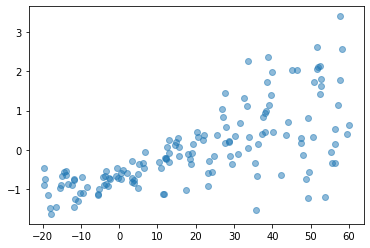

In [ ]:
plt.scatter(X, Y, alpha=0.5);

## Maximum Likelihood Estimation (MLE)
Maximum likelihood estimation is a method that determines values for the parameters of a model. The parameter values are found such that they maximise the likelihood that the process described by the model produced the data that were actually observed.
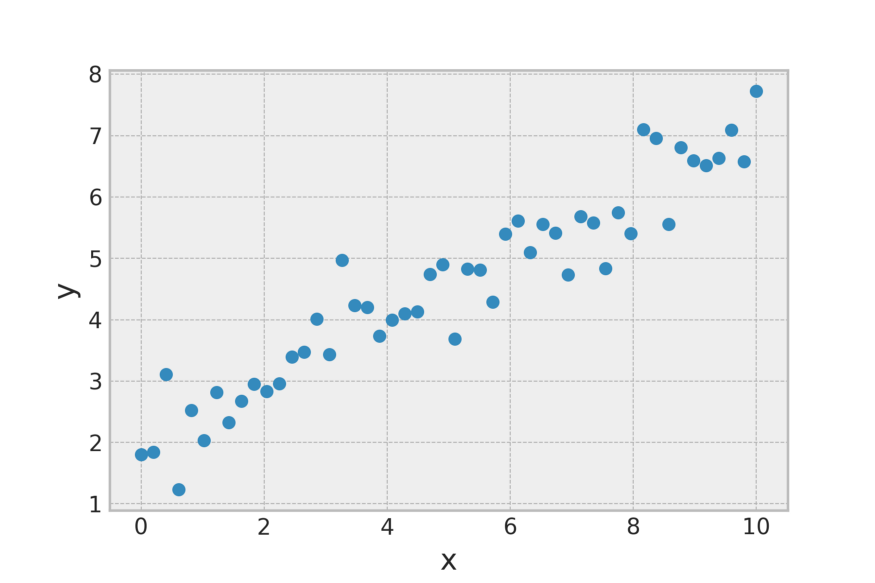

Let's say we want to model the data above which clearly has a linear relationship. So we'll model it with an equation of a line.
\begin{align}
y = \theta_{1}x + \theta_{0}
\end{align}
However, if the underlying relationship is linear, how do we account for the deviations we're seeing? Therefore, we're going to model the errors as being drawn from a Gaussian distribution with mean $0$ and variance $\sigma^{2}$
\begin{align}
\epsilon \sim N(0, \sigma^{2})\\
y = \theta_{1}x + \theta_{0} + \epsilon
\end{align}


### Derivation of MLE for regression
With the intuition above, we can start computing the **log likelihood**, which is the probability of the data given the parameters of the model. (in this case $\theta$, which consists of $\theta_{1}$ and $\theta_{0}$). Log likelihood is often used instead of likelihood for its nice mathematical properties. \\

The log likehood of our model is \\
\begin{align}
logp(y|X, \theta) = \sum^{N}_{i=1}logp(y_{i}|x_{i},\theta)
\end{align}
, where N is the size of our training set. \\
But since the noise $\epsilon$ is Gaussian, the likelihood is just
\begin{align}
logp(y|X, \theta) &= \sum_{i=1}^{N} logN(y_{i};\theta_{1}x+\theta_{0}, \sigma^{2})\\
&=\sum_{i=1}^{N} log\frac{1}{\sqrt{2\pi\sigma^{2}}}exp(-\frac{(y_{i}-(\theta_{1}x_{i}+\theta_{0}))^{2}}{2\sigma^{2}})\\
&= -\frac{N}{2}log2\pi\sigma^2 - \sum_{i=1}^{N}\frac{(y_{i}-(\theta_{1}x_{i}+\theta_{0}))^{2}}{2\sigma^{2}}
\end{align}
Now our objective is to find the $\theta$ that maximizes $logp(y|X, \theta)$. We can consider $\sigma$ as constant in this case (since we're not interested in optimizing $\sigma$ here) thus simplifying our objective funtion further:
\begin{align}
\theta_{MLE} &= \underset{\theta}{\arg\max}-\sum_{i=1}^{N}(y_{i}-(\theta_{1}x_{i}+\theta_{0}))^{2}\\
&= \underset{\theta}{\arg\min}\sum_{i=1}^{N}(y_{i}-(\theta_{1}x_{i}+\theta_{0}))^{2}\\
&=\underset{\theta}{\arg\min}MSE_{train}
\end{align}
This is why whenever we are minimizing MSE we're acutally maximizing the log likelihood!










In [ ]:
Image(url='https://miro.medium.com/max/1200/1*jxZFpWtCbD4jHPV0DdDuMA.gif')

From the [GIF](https://towardsdatascience.com/maximum-likelihood-estimation-984af2dcfcac) above, we see that as the parameter starts to model the data better and better, the log likelihood increases. The goal of MLE is to find the parameter that maximizes the log likelihood. <br>

### Coding Exercise: Implement MLE to fit the model
We're using 20 hidden units + 1 bias unit instead of 1 hidden unit + 1 bias unit in the example above in order for the model to learn a more complex function

In [ ]:
X = torch.tensor(X, dtype=torch.float)
Y = torch.tensor(Y, dtype=torch.float)

class MaximumLikelihood(nn.Module):
    def __init__(self):
        super().__init__()
        self.out = nn.Sequential(
            nn.Linear(1, 20),
            nn.ReLU(),
            nn.Linear(20, 1)
        )
    def forward(self, x):
        return self.out(x)
    
epochs = 200
m = MaximumLikelihood()
optim = torch.optim.Adam(m.parameters(), lr=0.01)

for epoch in range(epochs):
    optim.zero_grad()
    y_pred = m(X)
    loss = ((y_pred - Y)**2).mean()
    loss.backward()
    optim.step()

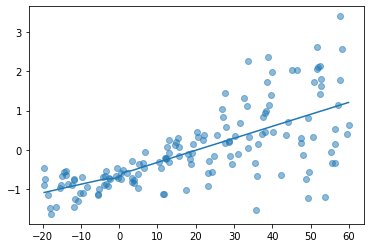

In [ ]:
plt.scatter(X, Y, alpha=0.5)
plt.plot(X.detach().numpy(), m(X).detach().numpy(), alpha=1);

If we train this model, we might observe a regression line like below. We are able to predict the expectation of y, but we are not able to make a statement about the noise of our predictions. The outputs are point estimates.


## Variational Inference


### Motivation
Let's say we want to obtain the distribution $p(y|x) \propto p(x|y)p(y)$. In variational infrence, we accept that we cannot obtain the true posterior $p(y|x)$ (due to numeric intractability in the marginalization), but we try to approximate this distribution with another distribution $q_{\phi}(y)$, where $\phi$ are the variational parameters. This distribution is what we call a variational distribution.

If we choose a factorized (diagonal) Gaussian variational distribution, $q_{\phi}(y)$ becomes $q_{\phi}(\mu, diag(\sigma^{2}))$. Finally, as we want the distribution $q$ to be dependent on x, we define a function (we can think of it as a feed-forward of our neural network) $g_{\phi}: x \mapsto \mu, \sigma$ such that $q_{\phi}(y|x)=N(g_{\phi}(x)_{\mu}, diag(g_{\phi}(x)_{\sigma^{2}})$. Thus our total model can be described as 
\begin{align}
\\
p(y) &= N(0, 1)\\
q(y|x) &= N(g_{\phi}(x)_{\mu}, diag(g_{\phi}(x)_{\sigma^{2}})
\end{align}

### Reparameterization trick
Now let's say we have successfully learned $q(y|x)$ that assembles $p(y|x)$, the obvious question becomes how do we get a single value y from q(y|x). Sure we can literally just sample from this distribution; however, doing so the gradient cannot flow through the model anymore (i.e. we cannot update $\mu$ and $\sigma$ respectively). To avoid this problem, instead of directly sampling from ;
$$
y \sim q(\mu, \sigma^{2}) = q(y|x)
$$
We sample from a unit gaussian and recreate samples from the variational distribution. Now the stochasticity of 
$\epsilon$ is external and will not prevent the flow of gradients.
$$
y = \mu + \sigma\odot\epsilon
$$
$$
\epsilon \sim N(0, 1)
$$


#### Coding Exercise: Define $g_{\phi}(x)_{\mu, \phi^{2}}$ and apply reparameterization
Note: since standard deviation cannot be negative, we're going to do a softplus on $\sigma$
$$
\sigma := softplus(\sigma) = log(1 + exp(\sigma))
$$

In [ ]:
class VI(nn.Module):
    def __init__(self):
        super().__init__()

        self.q_mu = nn.Sequential(
            nn.Linear(1, 20),
            nn.ReLU(),
            nn.Linear(20, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
        )
        self.q_log_var = nn.Sequential(
            nn.Linear(1, 20),
            nn.ReLU(),
            nn.Linear(20, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
        )
    def forward(self, x):
        mu = self.q_mu(x)
        log_var = F.softplus(self.q_log_var(x))
        return self.reparameterize(mu, log_var), mu, log_var

    def reparameterize(self, mu, log_var):
        eps = torch.randn_like(log_var)
        return mu + log_var * eps

### Evidence Lower Bound Loss (ELBO)
Ok, we now know how to sample from $q(y|x)$ using the reparameterization trick, but how do we find $q(y|x)$ in the first place? Here comes the ELBO loss

#### ELBO Derivation from KL(q||p)
So, let's just play around with KL to see what comes out of the other end

\begin{align}
D_{KL}(q(y|x)||p(y|x)) &= \sum q(y|x) \log \frac{q(y|x)}{p(y|x)}\\
&= -\sum q(y|x) \log \frac{p(y|x)}{q(y|x)}\\
&= -\sum q(y|x)  \left[\log p(y|x) - \log q(y|x) \right]\\
&= -\sum q(y|x) \left[\log \frac{p(x|y)p(y)}{p(x)} - \log q(y|x) \right]\\
&= -\sum q(y|x) \left[\log p(x|y) + \log p(y) - \log p(x) - \log q(y|x) \right]\\
&= \sum q(y|x) \left[-\log p(x|y) - \log p(y) + \log p(x) + \log q(y|x) \right]\\
\\
D_{KL}(q(y|x)||p(y|x)) - \sum q(y|x) \left[-\log p(x|y) - \log p(y) + \log q(y|x) \right] &= \log p(x)\\\\
-\sum q(y|x) \left[-\log p(x|y) + \log \frac{q(y|x)}{p(y)} \right] &=
\mathbb{E}_{y \sim q(y|x)} \left[-\log p(x|y) + \log \frac{q(y|x)}{p(y)} \right] \\
&=-\mathbb{E}_{q} \left[-\log p(x|y) + \log \frac{q(y|x)}{p(y)} \right] \\
&=\mathbb{E}_{q} \left[\log p(x|y) - \log \frac{q(y|x)}{p(y)} \right] \\
D_{KL}(q(y|x)||p(y|x)) + \left[ \mathbb{E}_{q} \log p(x|y)  - \mathbb{E}_{q}  \log \frac{q(y|x)}{p(y)} \right] &= \log p(x)\\
\end{align}

\\
To maximize the ELBO, we can minimize the negative of the ELBO.
$$
\max [\mathbb{E}_{q} \log p(x|y)  - \mathbb{E}_{q}  \log \frac{q(y|x)}{p(y)}] =
\min  - [\mathbb{E}_{q} \log p(x|y)  - \mathbb{E}_{q}  \log \frac{q(y|x)}{p(y)}] = \min  [\color{red}{\mathbb{E}_{q}[\log q(y|x) - \log p(y)]} - \color{blue}{\mathbb{E}_{q} \log p(x|y)}] = Loss
$$


Now we see that we have a loss function that enables us to maximize ELBO. The first term is the $\color{red}{KL\; divergence}$ and the second term is the $\color{blue}{likelihood\;(reconstruction)}$.
This loss is minimized when likelihood is maximized and the KL divergence is minimized.


#### Expected value with Monte Carlo
Like in MLE, the prior, the likelihood and the varitational distribution are all Gaussian, hence we only need to derive the log likelihood function for the Gaussian distribution.

$$
L(\mu,\sigma, D_{y}) = - \frac{n}{2}(2\pi\sigma^{2})-\frac{1}{2\sigma^{2}}\sum_{i=1}^{n}(D_{y_{i}}-u)^{2}
$$

This function will optimize the $\sigma$ and $\mu$


#### Coding Exercise: KL divergence intuition
Here we show the intuition of minimizing the KL

In [ ]:
p = torch.distributions.Normal(0, 1)
q = torch.distributions.Normal(2, 4)

y = q.rsample()

log_py = p.log_prob(y)
log_qyx = q.log_prob(y)

print('log prob pz: ', log_py, 'prob:', torch.exp(log_py))
print('log prob qzx: ', log_qyx, 'prob:', torch.exp(log_qyx))
print('old KL(q||p)=', log_qyx - log_py)

log prob pz:  tensor(-1.2943) prob: tensor(0.2741)
log prob qzx:  tensor(-2.5620) prob: tensor(0.0772)
old KL(q||p)= tensor(-1.2677)


In [ ]:
p = torch.distributions.Normal(0, 1)
# q = torch.distributions.Normal(2, 4) old q
q = torch.distributions.Normal(1, 2) # new q

log_py = p.log_prob(y)
log_qyx = q.log_prob(y)

print('log prob pz: ', log_py, 'prob:', torch.exp(log_py))
print('log prob qzx: ', log_qyx, 'prob:', torch.exp(log_qyx))
print('new KL(q||p)=', log_qyx - log_py)

log prob pz:  tensor(-1.2943) prob: tensor(0.2741)
log prob qzx:  tensor(-2.0475) prob: tensor(0.1291)
new KL(q||p)= tensor(-0.7533)


If we manually move q closer to p, we see that this distance has shrunk, minimizing our KL loss

## Implement the variational model (aleatoric uncertainty)
Now we have gone over all the necessary components in Variational Inference, we're going to implement it to model the aleatoric uncertainty of the data in PyTorch <br>


**Aleatoric uncertainty**: the uncertainty arising from the natural stochasticity of observations. Aleatoric uncertainty cannot be reduced even when more data is provided. <br>
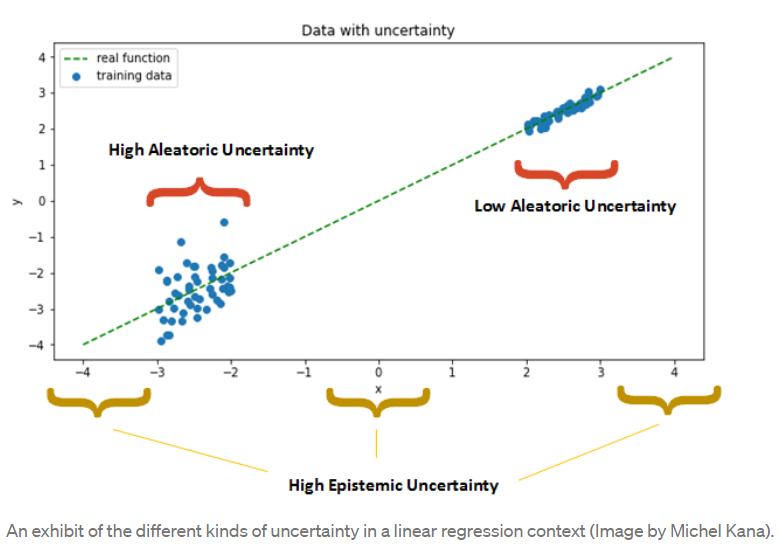
<br> 
[Image source](https://towardsdatascience.com/my-deep-learning-model-says-sorry-i-dont-know-the-answer-that-s-absolutely-ok-50ffa562cb0b)

In [ ]:
def ll_gaussian(y, mu, log_var):
    return -0.5 * torch.log(2 * np.pi * log_var**2) - (1 / (2 * log_var**2))* (y-mu)**2

In [ ]:
def neg_elbo(y_pred, y, mu, log_var):
    '''
    Using monte carlo sampling to approximate the expectation in the elbo loss
    '''
    # p(D|z): likelihood of observing y given variational mu and sigma
    likelihood = ll_gaussian(y, mu, log_var)
    
    # p(z): prior probability of y_pred
    log_prior = ll_gaussian(y_pred, torch.tensor(0), F.softplus(torch.tensor(1.)))
    
    # q(z|D): variational probability of y_pred
    log_p_q = ll_gaussian(y_pred, mu, log_var)

    # by taking the mean we approximate the expectation
    return (log_p_q - log_prior - likelihood).mean()

In [ ]:
epochs = 1500

m = VI()
optim = torch.optim.Adam(m.parameters(), lr=0.005)

for epoch in range(epochs):
    optim.zero_grad()
    y_pred, mu, log_var = m(X)
    loss = neg_elbo(y_pred, y, mu, log_var)
    loss.backward()
    optim.step()

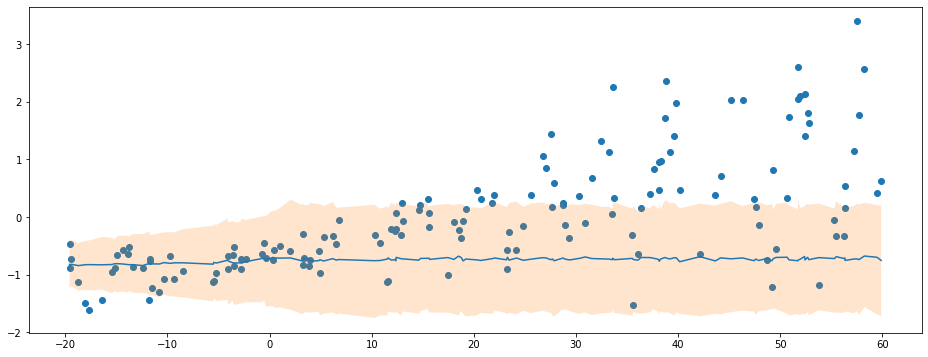

In [ ]:
# draw samples from Q(y) using monte-carlo sampling
with torch.no_grad():
    y_pred = torch.cat([m(X)[0] for _ in range(1000)], dim=1)
    
# Get some quantiles
q1, mu, q2 = np.quantile(y_pred, [0.05, 0.5, 0.95], axis=1)

plt.figure(figsize=(16, 6))
plt.scatter(X, Y)
plt.plot(X, mu)
plt.fill_between(X.flatten(), q1, q2, alpha=0.2);

We have succussfully modeled the **aleatoric uncertainty** above. We see that in regions where there is more noise in the data, our model tends to be more uncertain.

## Implement the variational model (epistemic uncertainty)
In the next part of this post we’ll show an example of modelling epistemic uncertainty with variational inference. The implementation is according to this paper [[Blundell 2015, Weight Uncertainty in Neural Networks]](https://arxiv.org/abs/1505.05424). We will now be modelling the weights $w$ of the neural network with distributions. A priori, our bayesian model consists of the following prior and likelihood.
$$
w \sim N(0, 1) \\
y \sim P(y|x, w)
$$
Again since the posterior $P(w|y, x)$ is intractable, we define the variational distribution;

$$
Q_{\theta}(w) \approx P(w)
$$
Our ELBO loss is the same as above with but now we're finding the posterior of $w$ given $D$ instead of $z$ given $D$
$$
\min  [\color{red}{\mathbb{E}_{q}[\log q(w|\theta) - \log p(w)]} - \color{blue}{\mathbb{E}_{q} \log p(D|w)}] = Loss
$$

Just as with the model we have defined earlier, we will approximate all the terms in the equation above by sampling $w \sim Q(w)$ The KL-divergence is not dependent on $D$, and can therefore be computed at the moment of sampling $w$

In [ ]:
class LinearVariational(nn.Module):
    """
    Mean field approximation of nn.Linear
    """
    def __init__(self, in_features, out_features, parent, n_batches, bias=True):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.include_bias = bias        
        self.parent = parent
        self.n_batches = n_batches
        
        if getattr(parent, 'accumulated_kl_div', None) is None:
            parent.accumulated_kl_div = 0
            
        # Initialize the variational parameters.
        # 𝑄(𝑤)=N(𝜇_𝜃,𝜎2_𝜃)
        # Do some random initialization with 𝜎=0.001
        self.w_mu = nn.Parameter(
            torch.FloatTensor(in_features, out_features).normal_(mean=0, std=0.001)
        )
        # proxy for variance
        # log(1 + exp(ρ))◦ eps
        self.w_p = nn.Parameter(
            torch.FloatTensor(in_features, out_features).normal_(mean=-2.5, std=0.001)
        )
        if self.include_bias:
            self.b_mu = nn.Parameter(
                torch.zeros(out_features)
            )
            # proxy for variance
            self.b_p = nn.Parameter(
                torch.zeros(out_features)
            )
        
    def reparameterize(self, mu, p):
        sigma = torch.log(1 + torch.exp(p)) 
        eps = torch.randn_like(sigma)
        return mu + (eps * sigma)
    
    def kl_divergence(self, z, mu_theta, p_theta, prior_sd=1):
        log_prior = dist.Normal(0, prior_sd).log_prob(z) 
        log_p_q = dist.Normal(mu_theta, torch.log(1 + torch.exp(p_theta))).log_prob(z) 
        return (log_p_q - log_prior).sum() / self.n_batches

    def forward(self, x):
        w = self.reparameterize(self.w_mu, self.w_p)
        
        if self.include_bias:
            b = self.reparameterize(self.b_mu, self.b_p)
        else:
            b = 0
            
        z = x @ w + b
        
        self.parent.accumulated_kl_div += self.kl_divergence(w, 
                                                             self.w_mu,
                                                             self.w_p, 
                                                             )
        if self.include_bias:
            self.parent.accumulated_kl_div += self.kl_divergence(b, 
                                                                 self.b_mu, 
                                                                 self.b_p,
                                                                 )
        return z

The code above shows the implementation of variational linear layer. The `__init__` method initializes variation parameter $\mu_{w}$ and $p_{w}$. In the `forward` method we sample the weights $w \sim N(\mu_{w}, diag(log(1+e^{p_w}))$ and the bias $b \sim N(\mu_{b}, diag(log(1+e^{p_b}))$ With these sampled neural networks parameters we do the forward pass of that layer $z = wx + b$. KL-divergence is calculated in the forward method as $D_{y}$ is not needed to calculate it.

### KL re-weighting
When optimizing with stochastic gradient descent, the KL-divergence needs to be weighed by $\frac{1}{M}$, where $M$ is the number of mini-batches per epoch.

###Bayesian neural network
This `LinearVariational` is the gist of a Bayesian neural network optimized with variational inference. In the code snippet below, we implement the same network as before. The only difference in the previous implementation is an auxiliary `dataclass` that will accumulate the KL-divergences of the variational layers. The code snippets below shows the final implementation, the loss function and the train loop.

In [ ]:
class KL:
    accumulated_kl_div = 0

class Model(nn.Module):
    def __init__(self, in_size, hidden_size, out_size, n_batches):
        super().__init__()
        self.kl_loss = KL
        
        self.layers = nn.Sequential(
            LinearVariational(in_size, hidden_size, self.kl_loss, n_batches),
            nn.ReLU(),
            LinearVariational(hidden_size, hidden_size, self.kl_loss, n_batches),
            nn.ReLU(),
            LinearVariational(hidden_size, out_size, self.kl_loss, n_batches)
        )
    
    @property
    def accumulated_kl_div(self):
        return self.kl_loss.accumulated_kl_div
    
    def reset_kl_div(self):
        self.kl_loss.accumulated_kl_div = 0
            
    def forward(self, x):
        return self.layers(x)

In [ ]:
epochs = 2000

def det_loss(y, y_pred, model):
    batch_size = y.shape[0]
    reconstruction_error = -dist.Normal(y_pred, .1).log_prob(y).sum()
    kl = model.accumulated_kl_div
    model.reset_kl_div()
    return reconstruction_error + kl

m = Model(1, 20, 1, n_batches=1)
optim = torch.optim.Adam(m.parameters(), lr=0.01)

for epoch in range(epochs):
    optim.zero_grad()
    y_pred = m(X)
    loss = det_loss(y_pred, Y, m)
    loss.backward()
    optim.step()

###Epistemic uncertainty
Below we evaluate the trained model by taking 1000 samples per data point. These samples are used to approximate quantities of the posterior predictive distribution such as the mean and the 
{
0.05
,
0.95
}
 quantiles. Intuitively, we can think of each 1 of the 1000 samples as a different neural network with slightly different parameters.

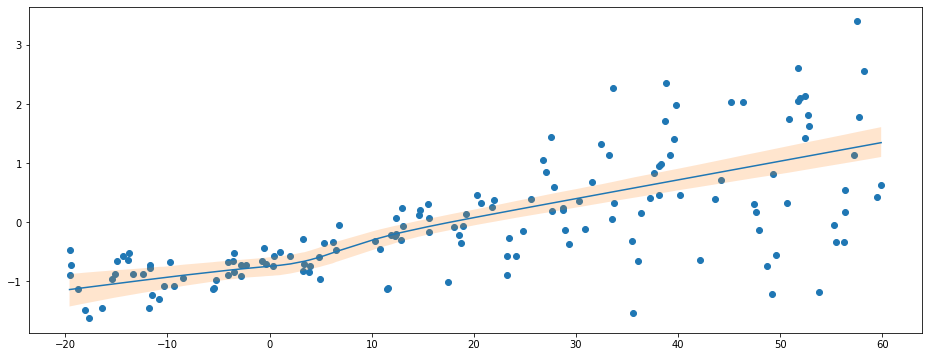

In [ ]:
with torch.no_grad():
    trace = np.array([m(X).flatten().numpy() for _ in range(1000)]).T
q_25, q_95 = np.quantile(trace, [0.05, 0.95], axis=1)
plt.figure(figsize=(16, 6))
plt.plot(X, trace.mean(1))
plt.scatter(X, Y)
plt.fill_between(X.flatten(), q_25, q_95, alpha=0.2)

Try our model on a different dataset

X shape: torch.Size([211, 1])
Y shape: torch.Size([211, 1])


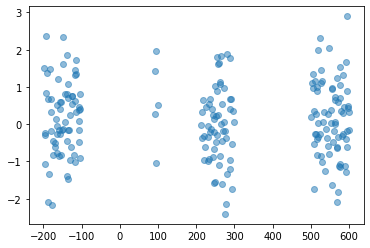

In [ ]:
def load_dataset_2(n=150):
    '''
    Generate an artificial dataset in which noise dependent on X
    Args:
      n: number of artificial points
    '''
    np.random.seed(43)

    w0 = 1/ 20
    b0 = 5
    x_range = [-200, 600]
    dinterval = [[-100, 90], [100,209], [300, 500]]

    x = (x_range[1] - x_range[0]) * np.random.rand(n) + x_range[0]
    eps = np.random.randn(n)
    y = eps
    idx = np.argsort(x)
    x = x[idx]
    y = y[idx]

    x_out = []
    y_out = []
    for i in range(len(x)):
      x_out.append(x[i])
      y_out.append(y[i])
    
      for interval in dinterval:
        if interval[0] < x[i] < interval[1]:
          x_out.pop(-1)
          y_out.pop(-1)
          break
    
    return np.array(x_out)[:, None], np.array(y_out)[:, None]

X, Y = load_dataset_2(500)
X = torch.tensor(X, dtype=torch.float)
Y = torch.tensor(Y, dtype=torch.float)
print('X shape:', X.shape)
print('Y shape:', Y.shape)

plt.scatter(X, Y, alpha=0.5);

In [ ]:
epochs = 1000

m = Model(1, 20, 1, n_batches=1)
optim = torch.optim.Adam(m.parameters(), lr=0.01)

for epoch in range(epochs):
    optim.zero_grad()
    y_pred = m(X)
    loss = det_loss(y_pred, Y, m)
    loss.backward()
    optim.step()

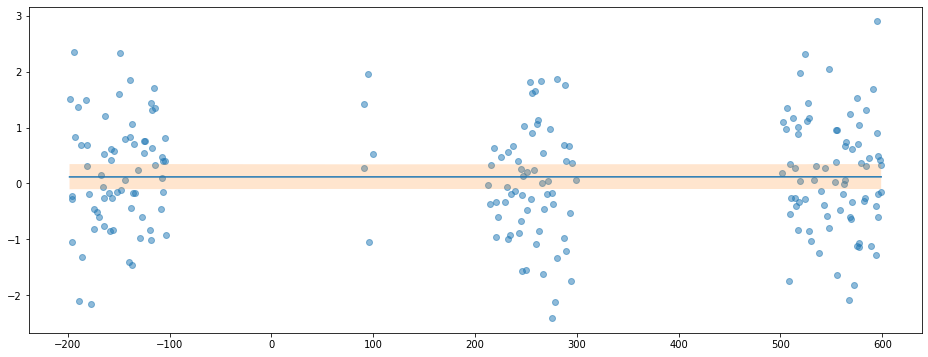

In [ ]:
with torch.no_grad():
    trace = np.array([m(X).flatten().numpy() for _ in range(1000)]).T
q_25, q_95 = np.quantile(trace, [0.05, 0.95], axis=1)
plt.figure(figsize=(16, 6))
plt.plot(X, trace.mean(1))
plt.scatter(X, Y, alpha=0.5)
plt.fill_between(X.flatten(), q_25, q_95, alpha=0.2)

# Classification (Bonus)

## Softmax Activation Function
The softmax activation function is often placed at the output layer of a neural network. It’s commonly used in multi-class learning problems where a set of features can be related to one-of-K classes. For example, in the CIFAR-10 image classification problem, given a set of pixels as input, we need to classify if a particular sample belongs to one-of-ten available classes: i.e., cat, dog, horse, etc.
Its equation is simple, we just have to compute for the normalized exponential function of all the units in the layer. In such case,
\begin{align}
S(y_{i}) = \frac{e^{y_{i}}}{\sum_{i}e^{y_{i}}}
\end{align}
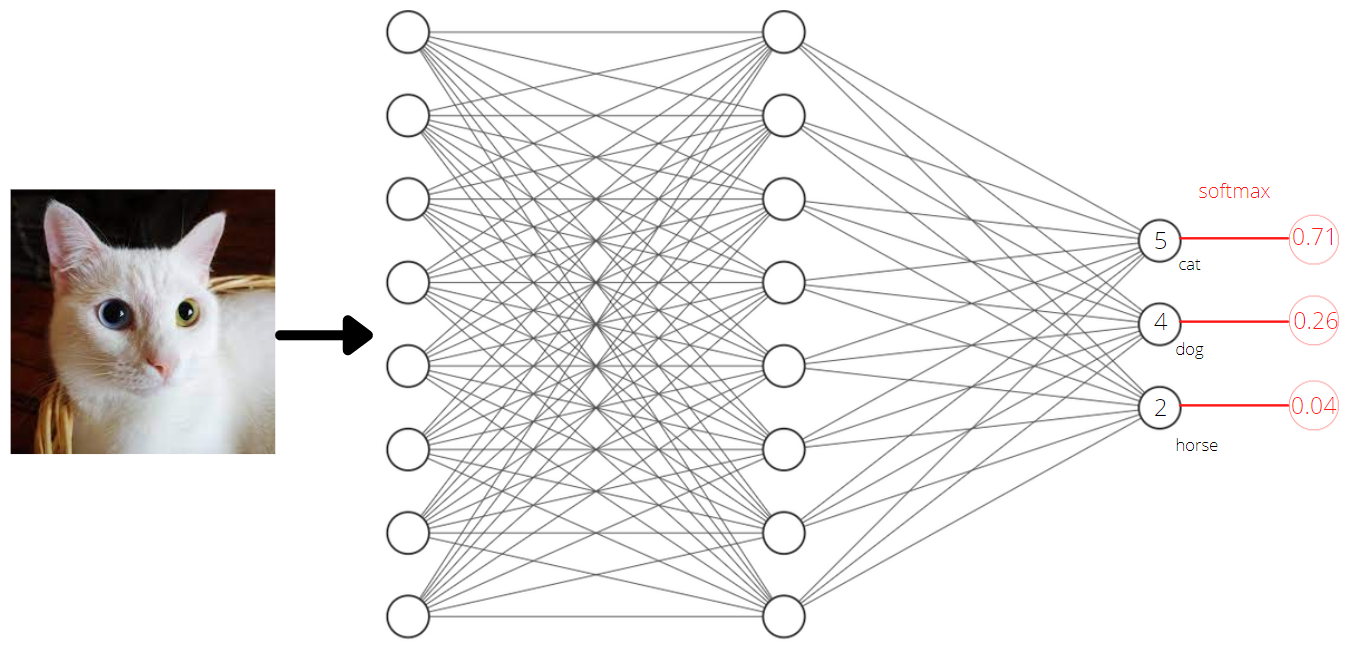

### Coding Exercise: Implement softmax activation function
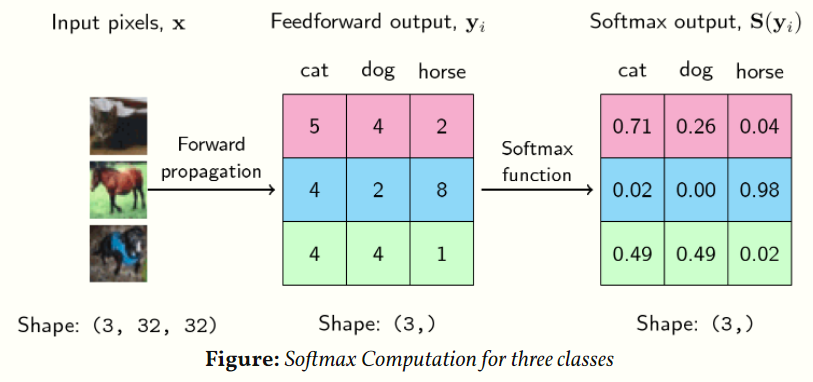<br>[Image source](https://ljvmiranda921.github.io/notebook/2017/08/13/softmax-and-the-negative-log-likelihood/)<br>

In [ ]:
# cat
forward_output = np.array([[5, 4, 2]], dtype=np.float)
target = np.array([0])
print(F.softmax(torch.tensor(forward_output), dim=-1))

# horse
forward_output = np.array([[4, 2, 8]], dtype=np.float)
target = np.array([2])
print(F.softmax(torch.tensor(forward_output), dim=-1))

# dog
forward_output = np.array([[4, 4, 1]], dtype=np.float)
target = np.array([1])
print(F.softmax(torch.tensor(forward_output), dim=-1))

tensor([[0.7054, 0.2595, 0.0351]], dtype=torch.float64)
tensor([[0.0179, 0.0024, 0.9796]], dtype=torch.float64)
tensor([[0.4879, 0.4879, 0.0243]], dtype=torch.float64)


## Negative Log Likelihood (NLL)
The negative log-likelihood becomes unhappy at smaller values, where it can reach infinite unhappiness (that’s too sad), and becomes less unhappy at larger values. Because we are summing the loss function to all the correct classes, what’s actually happening is that whenever the network assigns high confidence at the correct class, the unhappiness is low, but when the network assigns low confidence at the correct class, the unhappiness is high.
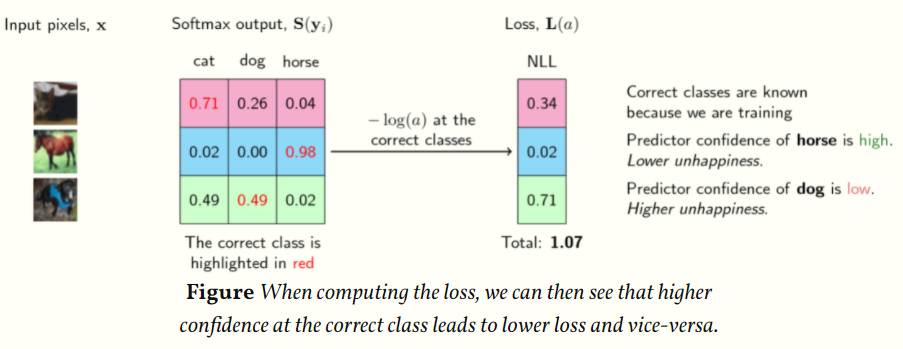<br>[Image source](https://ljvmiranda921.github.io/notebook/2017/08/13/softmax-and-the-negative-log-likelihood/)<br>
We're going to walk through the example above to see how NLL is calulated of multi-class classificaiton.
\begin{align}
NLL = \sum_{\color{red}\alpha \in S(y_{i})}^{} -log(\color{red}\alpha)\\
cat: \alpha = -log(0.71) \approx 0.34\\ 
horse: \alpha = -log(0.98) \approx 0.02\\
dog: \alpha = -log(0.49) \approx 0.71\\
NLL \approx 0.34 + 0.02 + 0.71 = 1.07
\end{align}


### Coding Exercise: Implement NLL

In [ ]:
# cat
forward_output = np.array([[5, 4, 2]], dtype=np.float)
target = np.array([0])
nll_cat = F.nll_loss(F.log_softmax(torch.tensor(forward_output), dim=-1), torch.tensor(target))
print(nll_cat)

# horse
forward_output = np.array([[4, 2, 8]], dtype=np.float)
target = np.array([2])
nll_horse = F.nll_loss(F.log_softmax(torch.tensor(forward_output), dim=-1), torch.tensor(target))
print(nll_horse)

# dog
forward_output = np.array([[4, 4, 1]], dtype=np.float)
target = np.array([1])
nll_dog = F.nll_loss(F.log_softmax(torch.tensor(forward_output), dim=-1), torch.tensor(target))
print(nll_dog)

NLL = nll_cat + nll_horse + nll_dog
print(NLL)

tensor(0.3490, dtype=torch.float64)
tensor(0.0206, dtype=torch.float64)
tensor(0.7177, dtype=torch.float64)
tensor(1.0873, dtype=torch.float64)


## Implement Binary Classification with TFP

# References
[Miranda, Understanding softmax and the negative log-likelihood](https://ljvmiranda921.github.io/notebook/2017/08/13/softmax-and-the-negative-log-likelihood/)<br>
[Fleshman, Maximum Likelihood Estimation](https://towardsdatascience.com/maximum-likelihood-estimation-984af2dcfcac)